<a href="https://colab.research.google.com/github/gustavochavesferreira/tp1_algoritmos2/blob/main/tp1_alg2_testes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
CREATE_TEST_FILES = False

In [ ]:
%%writefile lzw.py
import argparse
import time
import json
import sys
import os
import tracemalloc

class BitWriter:
    def __init__(self, file):
        self.file = file
        self.buffer = 0
        self.buffer_size = 0  # Número de bits atualmente no buffer

    def write_bits(self, data, num_bits):
        while num_bits > 0:
            remaining = 8 - self.buffer_size
            bits_to_write = min(num_bits, remaining)
            # Extrai os bits mais significativos
            bits = (data >> (num_bits - bits_to_write)) & ((1 << bits_to_write) - 1)
            self.buffer = (self.buffer << bits_to_write) | bits
            self.buffer_size += bits_to_write
            num_bits -= bits_to_write

            if self.buffer_size == 8:
                self.file.write(bytes([self.buffer]))
                self.buffer = 0
                self.buffer_size = 0

    def flush(self):
        if self.buffer_size > 0:
            self.buffer = self.buffer << (8 - self.buffer_size)
            self.file.write(bytes([self.buffer]))
            self.buffer = 0
            self.buffer_size = 0

class BitReader:
    def __init__(self, file):
        self.file = file
        self.buffer = 0
        self.buffer_size = 0  # Número de bits atualmente no buffer

    def read_bits(self, num_bits):
        result = 0
        while num_bits > 0:
            if self.buffer_size == 0:
                byte = self.file.read(1)
                if not byte:
                    return None  # Fim do arquivo
                self.buffer = byte[0]
                self.buffer_size = 8

            bits_to_read = min(num_bits, self.buffer_size)
            result = (result << bits_to_read) | ((self.buffer >> (self.buffer_size - bits_to_read)) & ((1 << bits_to_read) - 1))
            self.buffer_size -= bits_to_read
            num_bits -= bits_to_read
        return result

class LZW:
    def __init__(self, max_bits=12):
        self.max_bits = max_bits
        self.max_table_size = 2 ** self.max_bits
        self.stats = {
            'compression_ratio_over_time': [],
            'dictionary_size_over_time': [],
            'execution_time': 0,
            'memory_usage': 0
        }

    def compress(self, input_data):
        start_time = time.time()
        tracemalloc.start()

        # Inicializa o dicionário com bytes individuais
        dictionary = {bytes([i]): i for i in range(256)}
        string = b""
        compressed_data = []
        code = 256

        for symbol in input_data:
            symbol_byte = bytes([symbol])
            string_plus_symbol = string + symbol_byte
            if string_plus_symbol in dictionary:
                string = string_plus_symbol
            else:
                compressed_data.append(dictionary[string])
                if len(dictionary) < self.max_table_size:
                    dictionary[string_plus_symbol] = code
                    code += 1
                    self.stats['dictionary_size_over_time'].append(len(dictionary))
                string = symbol_byte

                # Atualiza estatísticas
                compressed_size = len(compressed_data) * self.max_bits
                original_size = len(input_data) * 8  # Assume 8 bits por byte
                compression_ratio = compressed_size / original_size
                self.stats['compression_ratio_over_time'].append(compression_ratio)

        if string:
            compressed_data.append(dictionary[string])

        # Calcula o tempo
        end_time = time.time()
        self.stats['execution_time'] = end_time - start_time

        # Calcula o uso de memória
        _, peak_memory = tracemalloc.get_traced_memory()
        self.stats['memory_usage'] = peak_memory / 1024  # Converte para KB
        tracemalloc.stop()

        return compressed_data

    def decompress(self, compressed_data):
        start_time = time.time()
        tracemalloc.start()


        # Inicializa o dicionário com bytes individuais
        dictionary = {i: bytes([i]) for i in range(256)}
        result = bytearray()
        code = 256

        if not compressed_data:
            print("Erro: Dados comprimidos estão vazios.")
            return bytes(result)

        prev_code = compressed_data.pop(0)
        string = dictionary[prev_code]
        result.extend(string)

        for curr_code in compressed_data:
            if curr_code in dictionary:
                entry = dictionary[curr_code]
            elif curr_code == code:
                entry = string + string[:1]
            else:
                raise ValueError(f"Código inválido: {curr_code}")

            result.extend(entry)

            if len(dictionary) < self.max_table_size:
                dictionary[code] = string + entry[:1]
                code += 1
                self.stats['dictionary_size_over_time'].append(len(dictionary))

            string = entry

        # Calcula o tempo
        end_time = time.time()
        self.stats['execution_time'] = end_time - start_time

        # Calcula o uso de memória
        _, peak_memory = tracemalloc.get_traced_memory()
        self.stats['memory_usage'] = peak_memory / 1024
        tracemalloc.stop()

        return bytes(result)

def run_lzw(mode, input_file, output_file, max_bits=12, stats_file=None):
    lzw = LZW(max_bits=max_bits)

    if mode == "compress":
        # Lê o arquivo de entrada em modo binário
        with open(input_file, "rb") as file:
            input_data = file.read()

        # Realiza a compressão
        compressed_data = lzw.compress(input_data)
        # print(f"Códigos comprimidos: {compressed_data}")

        # Escreve os dados comprimidos usando BitWriter
        with open(output_file, "wb") as file:
            bit_writer = BitWriter(file)
            for data in compressed_data:
                bit_writer.write_bits(data, lzw.max_bits)
            bit_writer.flush()

        print(f"Compressão concluída. Arquivo salvo em {output_file}")

        # Calcula a taxa de compressão
        compressed_size = len(compressed_data) * max_bits
        original_size = len(input_data) * 8  # Assume 8 bits por byte
        compression_ratio = compressed_size / original_size

        # Exporta os dados comprimidos para um arquivo JSON
        compressed_json_file = output_file + ".json"
        with open(compressed_json_file, "w") as json_file:
            json.dump(compressed_data, json_file, indent=4)
        print(f"Códigos comprimidos salvos em {compressed_json_file}")

        # Salva as estatísticas se solicitado
        if stats_file:
            stats = {
                'compression_ratio_over_time': lzw.stats['compression_ratio_over_time'],
                'dictionary_size_over_time': lzw.stats['dictionary_size_over_time'],
                'execution_time': lzw.stats['execution_time'],
                'memory_usage': lzw.stats['memory_usage']
            }
            with open(stats_file, "w") as f:
                json.dump(stats, f, indent=4)
            print(f"Estatísticas salvas em {stats_file}")

    elif mode == "decompress":
        print(f"Iniciando descompressão de {input_file}...")
        # Lê os dados comprimidos usando BitReader
        compressed_data = []
        with open(input_file, "rb") as file:
            bit_reader = BitReader(file)
            while True:
                data = bit_reader.read_bits(lzw.max_bits)
                if data is None:
                    break
                compressed_data.append(data)

        print(f"Comprimento dos dados comprimidos: {len(compressed_data)}")

        if not compressed_data:
            print("Erro: Arquivo comprimido está vazio ou corrompido.")
            sys.exit(1)

        # Realiza a descompressão
        try:
            decompressed_data = lzw.decompress(compressed_data)
        except Exception as e:
            print(f"Erro durante a descompressão: {e}")
            sys.exit(1)

        # print(f"Dados descomprimidos: {decompressed_data.decode('utf-8', errors='ignore')}")
        print(f"Comprimento dos dados descomprimidos: {len(decompressed_data)}")

        # Escreve os dados descomprimidos em modo binário
        with open(output_file, "wb") as file:
            file.write(decompressed_data)

        print(f"Descompressão concluída. Arquivo salvo em {output_file}")

        # Salva as estatísticas se solicitado
        if stats_file:
            stats = {
                'execution_time': lzw.stats['execution_time'],
                'memory_usage': lzw.stats['memory_usage']
            }
            with open(stats_file, "w") as f:
                json.dump(stats, f, indent=4)
            print(f"Estatísticas salvas em {stats_file}")

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Compressão e Descompressão usando LZW")
    parser.add_argument("mode", choices=["compress", "decompress"], help="Modo de operação")
    parser.add_argument("input_file", help="Arquivo de entrada")
    parser.add_argument("output_file", help="Arquivo de saída")
    parser.add_argument("--max-bits", type=int, default=12, help="Número máximo de bits (padrão: 12)")
    parser.add_argument("--stats-file", help="Arquivo para salvar estatísticas em formato JSON")

    # Verifica se está em um ambiente interativo
    if 'ipykernel' in sys.modules:
        # Defina os argumentos manualmente para testes no notebook
        # Ajuste conforme necessário para testes
        args = parser.parse_args([
            'compress',            # ou 'decompress' conforme necessário
            'input.txt',           # Substitua pelo arquivo de entrada correto
            'output.lzw',          # Substitua pelo arquivo de saída correto
            '--max-bits', '12',
            '--stats-file', 'stats.json'
        ])
    else:
        args = parser.parse_args()

    run_lzw(args.mode, args.input_file, args.output_file, args.max_bits, args.stats_file)

Overwriting lzw.py


In [ ]:
!python3 lzw.py compress input.txt output.lzw --max-bits 12 --stats-file compress_stats.json

Compressão concluída. Arquivo salvo em output.lzw
Códigos comprimidos salvos em output.lzw.json
Estatísticas salvas em compress_stats.json


In [ ]:
!python3 lzw.py decompress output.lzw decompressed.txt --max-bits 12 --stats-file decompress_stats.json

Iniciando descompressão de output.lzw...
Comprimento dos dados comprimidos: 65
Comprimento dos dados descomprimidos: 76
Descompressão concluída. Arquivo salvo em decompressed.txt
Estatísticas salvas em decompress_stats.json


In [ ]:
import filecmp

if filecmp.cmp("input.txt", "decompressed.txt", shallow=False):
    print("Sucesso: O arquivo descomprimido é idêntico ao original.")
else:
    print("Erro: O arquivo descomprimido difere do original.")

Sucesso: O arquivo descomprimido é idêntico ao original.


In [ ]:
with open('output.lzw', 'rb') as file:
    # Lê o conteúdo como bytes
    data = file.read()

# Converte os bytes para uma representação binária
binary_data = ''.join(format(byte, '08b') for byte in data)
print("Dados comprimidos (binário):", binary_data)

# Converte os dados em inteiros (assumindo 12 bits por código)
num_bits = 12
codes = []
buffer = 0
buffer_size = 0

for byte in data:
    buffer = (buffer << 8) | byte
    buffer_size += 8

    while buffer_size >= num_bits:
        code = (buffer >> (buffer_size - num_bits)) & ((1 << num_bits) - 1)
        codes.append(code)
        buffer_size -= num_bits

print("Códigos comprimidos:", codes)

Dados comprimidos (binário): 0000010101000000010001010000010100110000010101000000010000010000010011100000010001000000010011110000001000000000010000110000010011110000010011010000010100000000010100100001000000010000010100110000010000010001000001110000010101010000010101000000010010010000010011000000010010010000010110100001000001000001000001100000001000000000010011000000010110100000010101110000001000000000010100000000010000010000010100100000010000010000001000000001000001110000010101000001001000010000010000100000010000010000010011000000010010000001000001110001000011000000010000010001000100110001000010010000001000000000001100010000001000000000010001000000010001010000001000000001001010000000010001110000010011110000010100100000010010010000010101000000010011010000010011110000010100110000001000000000001100100000
Códigos comprimidos: [84, 69, 83, 84, 65, 78, 68, 79, 32, 67, 79, 77, 80, 82, 257, 83, 65, 263, 85, 84, 73, 76, 73, 90, 260, 262, 32, 76, 90, 87, 32, 80, 65, 82, 65, 32, 263, 84, 289, 66

In [ ]:
print("Conteúdo do arquivo original:")
!cat input.txt

print("\nConteúdo do arquivo comprimido:")
!cat output.lzw

print("\nConteúdo do arquivo descomprimido:")
!cat decompressed.txt

Conteúdo do arquivo original:
TESTANDO COMPRESSAO UTILIZANDO LZW PARA O TRABALHO PRATICO 1 DE ALGORITMOS 2
Conteúdo do arquivo comprimido:
@E0TN@O C�M RSPT�L�ZA L�W PR pTBL��A1	 1 DP �G�R�T�O0  
Conteúdo do arquivo descomprimido:
TESTANDO COMPRESSAO UTILIZANDO LZW PARA O TRABALHO PRATICO 1 DE ALGORITMOS 2

In [ ]:
import os
import shutil
from PIL import Image

if CREATE_TEST_FILES:
    # Diretórios para os arquivos de teste
    # sizes = ['small', 'medium']
    sizes = ['small', 'medium', 'large']
    os.makedirs('test_files/small', exist_ok=True)
    os.makedirs('test_files/medium', exist_ok=True)
    os.makedirs('test_files/large', exist_ok=True)

    # Função para gerar arquivos de texto
    def generate_text_file(size, filename):
        if size == 'small':
            multiplier = 1000    # ~10 KB
            content = "Este é um texto de teste.\n" * multiplier
        elif size == 'medium':
            multiplier = 20000   # ~1 MB
            content = "Lorem ipsum dolor sit amet, consectetur adipiscing elit.\n" * multiplier
        elif size == 'large':
            multiplier = 200000  # >10 MB
            content = "O rápido guaxinim marrom saltou sobre o cachorro preguiçoso.\n" * multiplier
        with open(filename, 'w') as f:
            f.write(content)

    # Função para gerar imagens bitmap
    def generate_image_file(size, filename):
        if size == 'small':
            dimensions = (100, 100)
        elif size == 'medium':
            dimensions = (1000, 1000)
        elif size == 'large':
            dimensions = (5000, 5000)
        image = Image.new('RGB', dimensions, color='red')
        image.save(filename)

    # Função para gerar arquivos binários
    def generate_binary_file(size, filename):
        if size == 'small':
            num_bytes = 10 * 1024    # ~10 KB
        elif size == 'medium':
            num_bytes = 1 * 1024 * 1024   # ~1 MB
        elif size == 'large':
            num_bytes = 15 * 1024 * 1024  # >10 MB
        with open(filename, 'wb') as f:
            f.write(os.urandom(num_bytes))

    # Gerando os arquivos
    for size in sizes:
        # Arquivos de texto
        text_filename = f'test_files/{size}/{size}_text.txt'
        generate_text_file(size, text_filename)

        # Imagens bitmap
        image_filename = f'test_files/{size}/{size}_image.bmp'
        generate_image_file(size, image_filename)

        # Arquivos binários
        binary_filename = f'test_files/{size}/{size}_binary.bin'
        generate_binary_file(size, binary_filename)
    print("Arquivos de teste criados com sucesso.")
else:
    print("Criação de arquivos de teste desabilitada.")

In [ ]:
import subprocess

sizes = ['small', 'medium', 'large']
file_types = {
    'text': '.txt',
    'image': '.bmp',
    'binary': '.bin'
}

for size in sizes:
    for ftype, extension in file_types.items():
        input_file = f'test_files/{size}/{size}_{ftype}{extension}'
        output_file = f'test_files/{size}/{size}_{ftype}.lzw'
        stats_file = f'test_files/{size}/{size}_{ftype}_compress_stats.json'

        command = [
            'python', 'lzw.py', 'compress', input_file, output_file,
            '--max-bits', '12', '--stats-file', stats_file
        ]

        print(f'Compressing {input_file}...')
        result = subprocess.run(command, capture_output=True, text=True)

        if result.returncode != 0:
            print(f"Error compressing {input_file}:")
            print(result.stderr)
        else:
            print(result.stdout)

Compressing test_files/small/small_text.txt...
Compressão concluída. Arquivo salvo em test_files/small/small_text.lzw
Códigos comprimidos salvos em test_files/small/small_text.lzw.json
Estatísticas salvas em test_files/small/small_text_compress_stats.json

Compressing test_files/small/small_image.bmp...
Compressão concluída. Arquivo salvo em test_files/small/small_image.lzw
Códigos comprimidos salvos em test_files/small/small_image.lzw.json
Estatísticas salvas em test_files/small/small_image_compress_stats.json

Compressing test_files/small/small_binary.bin...
Compressão concluída. Arquivo salvo em test_files/small/small_binary.lzw
Códigos comprimidos salvos em test_files/small/small_binary.lzw.json
Estatísticas salvas em test_files/small/small_binary_compress_stats.json

Compressing test_files/medium/medium_text.txt...
Compressão concluída. Arquivo salvo em test_files/medium/medium_text.lzw
Códigos comprimidos salvos em test_files/medium/medium_text.lzw.json
Estatísticas salvas em tes

In [ ]:
for size in sizes:
    for ftype, extension in file_types.items():
        input_file = f'test_files/{size}/{size}_{ftype}.lzw'
        output_file = f'test_files/{size}/{size}_{ftype}_decompressed{extension}'
        stats_file = f'test_files/{size}/{size}_{ftype}_decompress_stats.json'

        command = [
            'python', 'lzw.py', 'decompress', input_file, output_file,
            '--max-bits', '12', '--stats-file', stats_file
        ]

        print(f'Decompressing {input_file}...')
        result = subprocess.run(command, capture_output=True, text=True)

        if result.returncode != 0:
            print(f"Error decompressing {input_file}:")
            print(result.stderr)
        else:
            print(result.stdout)

Decompressing test_files/small/small_text.lzw...
Iniciando descompressão de test_files/small/small_text.lzw...
Comprimento dos dados comprimidos: 1186
Comprimento dos dados descomprimidos: 27000
Descompressão concluída. Arquivo salvo em test_files/small/small_text_decompressed.txt
Estatísticas salvas em test_files/small/small_text_decompress_stats.json

Decompressing test_files/small/small_image.lzw...
Iniciando descompressão de test_files/small/small_image.lzw...
Comprimento dos dados comprimidos: 451
Comprimento dos dados descomprimidos: 30054
Descompressão concluída. Arquivo salvo em test_files/small/small_image_decompressed.bmp
Estatísticas salvas em test_files/small/small_image_decompress_stats.json

Decompressing test_files/small/small_binary.lzw...
Iniciando descompressão de test_files/small/small_binary.lzw...
Comprimento dos dados comprimidos: 9776
Comprimento dos dados descomprimidos: 10240
Descompressão concluída. Arquivo salvo em test_files/small/small_binary_decompressed.b

In [ ]:
import filecmp
import os

for size in sizes:
    for ftype, extension in file_types.items():
        original_file = f'test_files/{size}/{size}_{ftype}{extension}'
        decompressed_file = f'test_files/{size}/{size}_{ftype}_decompressed{extension}'

        if os.path.exists(decompressed_file):
            files_are_equal = filecmp.cmp(original_file, decompressed_file, shallow=False)
            if files_are_equal:
                print(f'{size.capitalize()} {ftype} file decompressed successfully.')
            else:
                print(f'Error: {size} {ftype} file decompressed incorrectly.')
        else:
            print(f'Error: Decompressed file {decompressed_file} not found.')

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações para melhor visualização dos gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Coletar e Organizar os Dados

In [ ]:
sizes = ['small', 'medium', 'large']
file_types = {
    'text': '.txt',
    'image': '.bmp',
    'binary': '.bin'
}

compression_data = []
decompression_data = []

for size in sizes:
    for ftype, extension in file_types.items():
        # Caminhos para os arquivos de estatísticas de compressão e descompressão
        compress_stats_file = f'test_files/{size}/{size}_{ftype}_compress_stats.json'
        decompress_stats_file = f'test_files/{size}/{size}_{ftype}_decompress_stats.json'

        # Verificar se o arquivo de compressão existe e carregar os dados
        if os.path.exists(compress_stats_file):
            with open(compress_stats_file, 'r') as f:
                compress_stats = json.load(f)

            # Adicionar os dados de compressão à lista
            compression_data.append({
                'Size': size,
                'File_Type': ftype,
                'Compression_Ratio': compress_stats.get('compression_ratio_over_time', [])[-1],  # Último valor
                'Dictionary_Size': compress_stats.get('dictionary_size_over_time', [])[-1] if compress_stats.get('dictionary_size_over_time') else None,
                'Compression_Time(s)': compress_stats.get('execution_time', 0),
                'Memory_Usage(KB)': compress_stats.get('memory_usage', 0)
            })
        else:
            print(f"Compress stats file not found: {compress_stats_file}")

        # Verificar se o arquivo de descompressão existe e carregar os dados
        if os.path.exists(decompress_stats_file):
            with open(decompress_stats_file, 'r') as f:
                decompress_stats = json.load(f)

            # Adicionar os dados de descompressão à lista
            decompression_data.append({
                'Size': size,
                'File_Type': ftype,
                'Decompression_Time(s)': decompress_stats.get('execution_time', 0)
            })
        else:
            print(f"Decompress stats file not found: {decompress_stats_file}")

# Criar DataFrames
compression_df = pd.DataFrame(compression_data)
decompression_df = pd.DataFrame(decompression_data)

# Exibir os DataFrames
print("Dados de Compressão:")
display(compression_df)

print("Dados de Descompressão:")
display(decompression_df)

Dados de Compressão:


Gráficos de Comparação

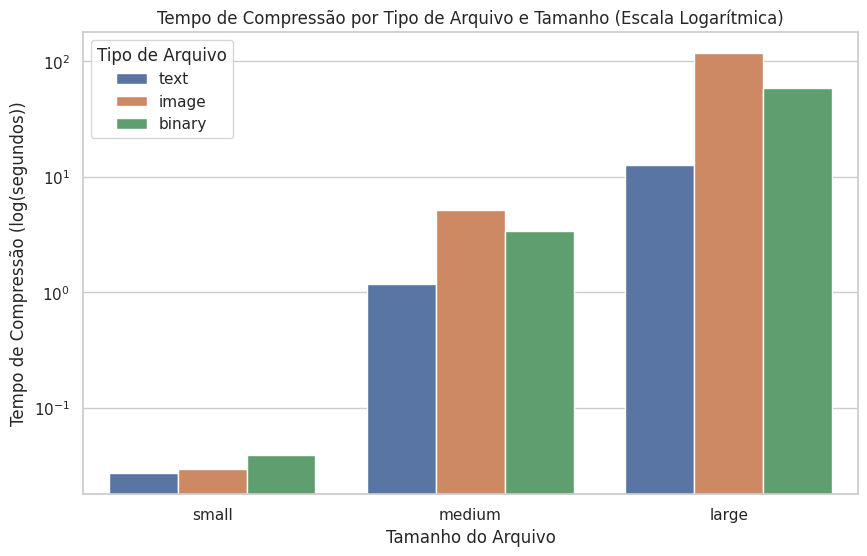

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Size', y='Compression_Time(s)', hue='File_Type', data=compression_df)
plt.yscale('log')
plt.title('Tempo de Compressão por Tipo de Arquivo e Tamanho (Escala Logarítmica)')
plt.xlabel('Tamanho do Arquivo')
plt.ylabel('Tempo de Compressão (log(segundos))')
plt.legend(title='Tipo de Arquivo')
plt.show()

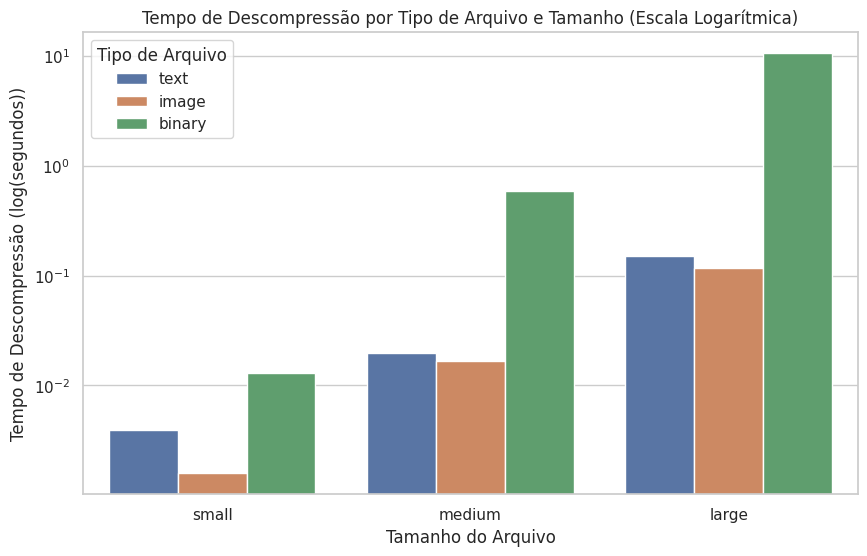

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Size', y='Decompression_Time(s)', hue='File_Type', data=decompression_df)
plt.yscale('log')
plt.title('Tempo de Descompressão por Tipo de Arquivo e Tamanho (Escala Logarítmica)')
plt.xlabel('Tamanho do Arquivo')
plt.ylabel('Tempo de Descompressão (log(segundos))')
plt.legend(title='Tipo de Arquivo')
plt.show()

Taxa de Compressão por Tipo de Arquivo e Tamanho

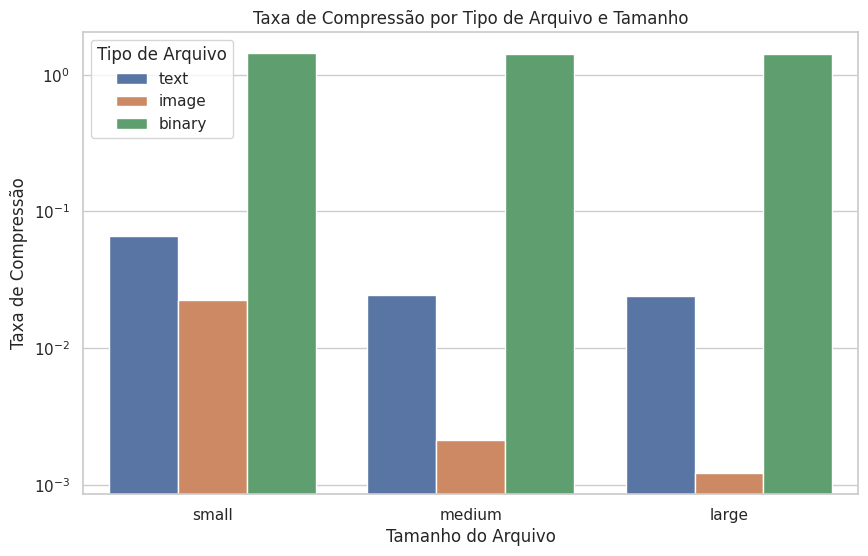

In [ ]:
# Taxa de Compressão
plt.figure(figsize=(10, 6))
sns.barplot(x='Size', y='Compression_Ratio', hue='File_Type', data=compression_df)
plt.yscale('log')
plt.title('Taxa de Compressão por Tipo de Arquivo e Tamanho')
plt.xlabel('Tamanho do Arquivo')
plt.ylabel('Taxa de Compressão')
plt.legend(title='Tipo de Arquivo')
plt.show()


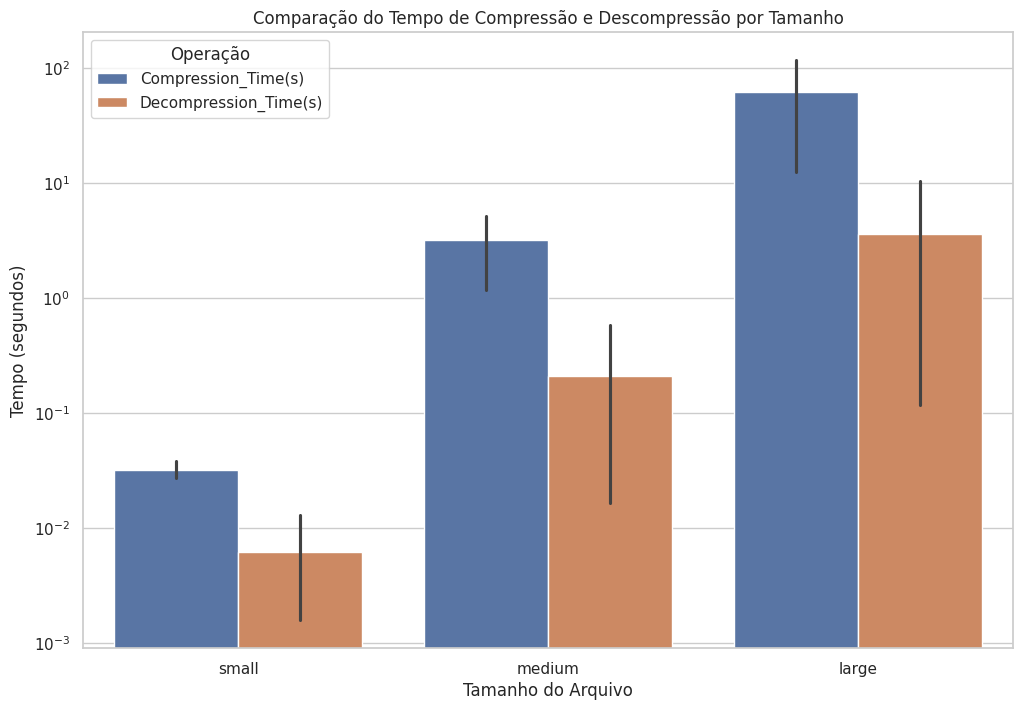

In [ ]:
# Comparação de Tempos de Compressão e Descompressão
merged_df = pd.merge(compression_df, decompression_df, on=['Size', 'File_Type'], how='inner')
merged_df_melted = merged_df.melt(id_vars=['Size', 'File_Type'],
                                   value_vars=['Compression_Time(s)', 'Decompression_Time(s)'],
                                   var_name='Operation',
                                   value_name='Time(s)')

plt.figure(figsize=(12, 8))
sns.barplot(x='Size', y='Time(s)', hue='Operation', data=merged_df_melted)
plt.yscale('log')
plt.title('Comparação do Tempo de Compressão e Descompressão por Tamanho')
plt.xlabel('Tamanho do Arquivo')
plt.ylabel('Tempo (segundos)')
plt.legend(title='Operação')
plt.show()

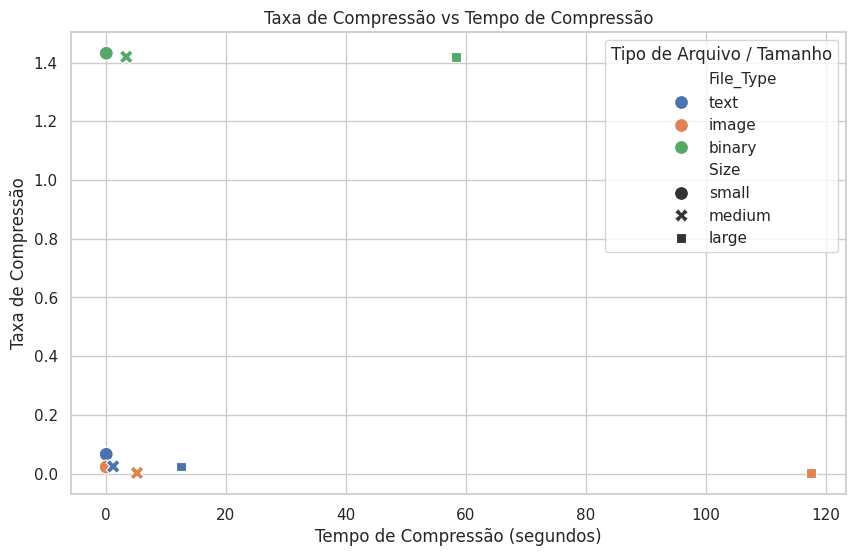

In [ ]:
# Taxa de Compressão vs Tempo de Compressão
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Compression_Time(s)', y='Compression_Ratio', hue='File_Type', style='Size', data=compression_df, s=100)
plt.title('Taxa de Compressão vs Tempo de Compressão')
plt.xlabel('Tempo de Compressão (segundos)')
plt.ylabel('Taxa de Compressão')
plt.legend(title='Tipo de Arquivo / Tamanho')
plt.show()

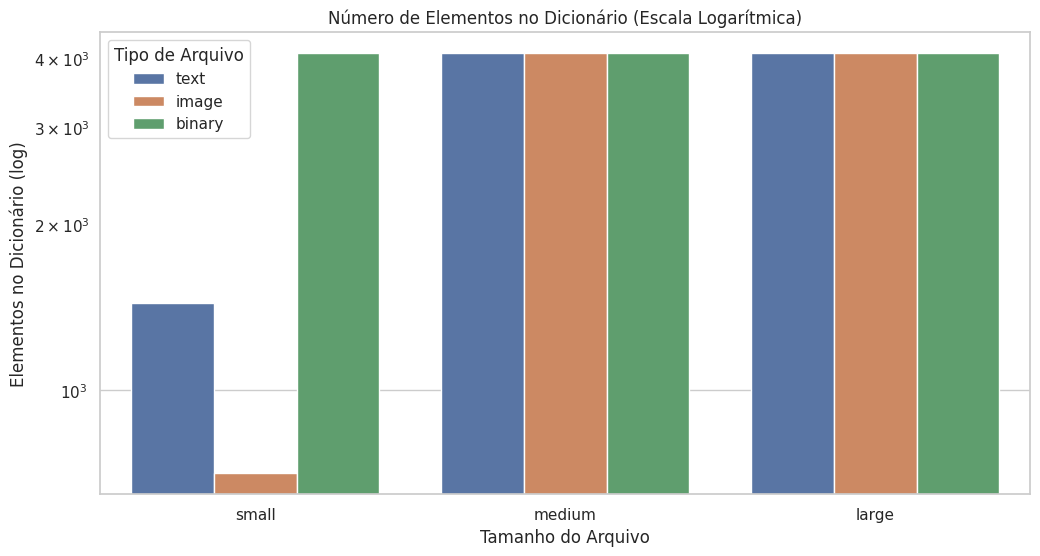

In [ ]:
# Gráfico do número de elementos no dicionário
plt.figure(figsize=(12, 6))
plt.yscale("log")
sns.barplot(x='Size', y='Dictionary_Size', hue='File_Type', data=compression_df)
plt.title('Número de Elementos no Dicionário (Escala Logarítmica)')
plt.xlabel('Tamanho do Arquivo')
plt.ylabel('Elementos no Dicionário (log)')
plt.legend(title='Tipo de Arquivo')
plt.show()

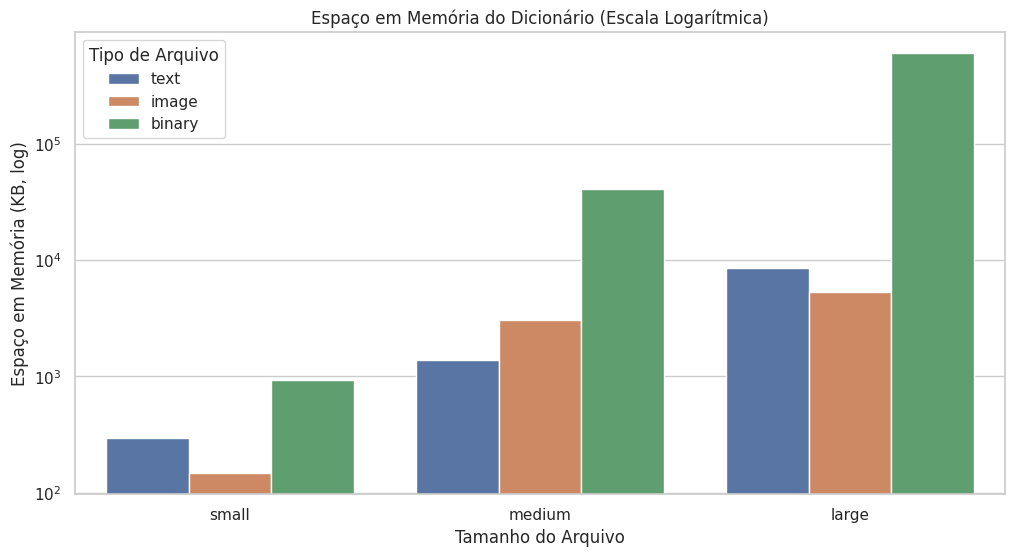

In [ ]:
# Gráfico do espaço em memória do dicionário
plt.figure(figsize=(12, 6))
plt.yscale("log")
sns.barplot(x='Size', y='Memory_Usage(KB)', hue='File_Type', data=compression_df)
plt.title('Espaço em Memória do Dicionário (Escala Logarítmica)')
plt.xlabel('Tamanho do Arquivo')
plt.ylabel('Espaço em Memória (KB, log)')
plt.legend(title='Tipo de Arquivo')
plt.show()

In [ ]:
!zip -r pasta.zip /content/

from google.colab import files
files.download('pasta.zip')

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2024.11.14/ (stored 0%)
  adding: content/.config/logs/2024.11.14/14.25.02.296080.log (deflated 58%)
  adding: content/.config/logs/2024.11.14/14.24.48.387435.log (deflated 57%)
  adding: content/.config/logs/2024.11.14/14.25.01.300026.log (deflated 85%)
  adding: content/.config/logs/2024.11.14/14.24.26.637550.log (deflated 93%)
  adding: content/.config/logs/2024.11.14/14.25.15.677507.log (deflated 56%)
  adding: content/.config/logs/2024.11.14/14.25.14.950547.log (deflated 57%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/hidden_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>